In [1]:
import os, simplejson, pickle, time, parameter

from cluster_model import ClusterModel
from state_optimization import StateOptimization
from datetime import datetime, timedelta
from gurobipy import GRB
from shapely.geometry import shape, Point, Polygon, MultiPolygon
from shapely.ops import nearest_points
from matplotlib.lines import Line2D
from geojson import load

import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import integer_programming as ip
import networkx as nx


In [2]:
with open('../data/station_data/2024 model/v2/tph_4/data.pickle', 'rb') as f:
    station_data = pickle.load(f)
    
with open('../station_information.json', 'r') as f:
    station_information = simplejson.load(f)['data']['stations']
    
with open('../data/ideal_states/bounds.pickle', 'rb') as f:
    bounds = pickle.load(f)

tph = 4
square_size = 0.005

In [3]:
model = ClusterModel(station_data=station_data, in_transit=[], tph=tph)
model.init_clusters(square_length=square_size)

model_2 = ClusterModel(station_data=station_data, in_transit=[], tph=4)
model_2.init_clusters(square_length=square_size)

start_df = parameter.get_state_df(station_information, f'rebalancing/data/9/2024-07-09-10-00.pickle')
end_df = parameter.get_state_df(station_information, f'rebalancing/data/9/2024-07-09-14-00.pickle')
model.init_df_state(start_df, time=timedelta(hours=6))
model_2.init_df_state(end_df, time=timedelta(hours=10))

original_state = {i: model.cluster_dict[i].curr_bikes for i in model.cluster_dict}
end_state = {i: model_2.cluster_dict[i].curr_bikes for i in model_2.cluster_dict}
original_clusters = {cluster.name: cluster for cluster in model.cluster_dict.values()}

state_optimization = StateOptimization(model)

36 horizontal squares and 51 vertical squares. Total squares: 1836
36 horizontal squares and 51 vertical squares. Total squares: 1836


In [4]:
for cluster in model.cluster_dict.values():
    cluster.rate = [rate*1.75 for rate in cluster.rate]

In [5]:
opt_state = state_optimization.optimize(length=timedelta(hours=14), steps=4, min=1.4)

Step 1 of 4 completed 9210 failures
Step 2 of 4 completed 7616 failures
Step 3 of 4 completed 4973 failures
Step 4 of 4 completed 4387 failures


Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.5.0 22F66)

CPU model: Intel(R) Core(TM) i9-9980HK CPU @ 2.40GHz
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 234861 rows, 136447 columns and 1032594 nonzeros
Model fingerprint: 0xce6a9b2f
Variable types: 0 continuous, 136447 integer (67760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 37797 rows and 35280 columns
Presolve time: 4.72s
Presolved: 197064 rows, 101167 columns, 855622 nonzeros
Variable types: 0 continuous, 101167 integer (67646 binary)
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 5.87 seconds (5.36 work units)
Thread count was 16 (of 16 available processors)

Solution count 1:

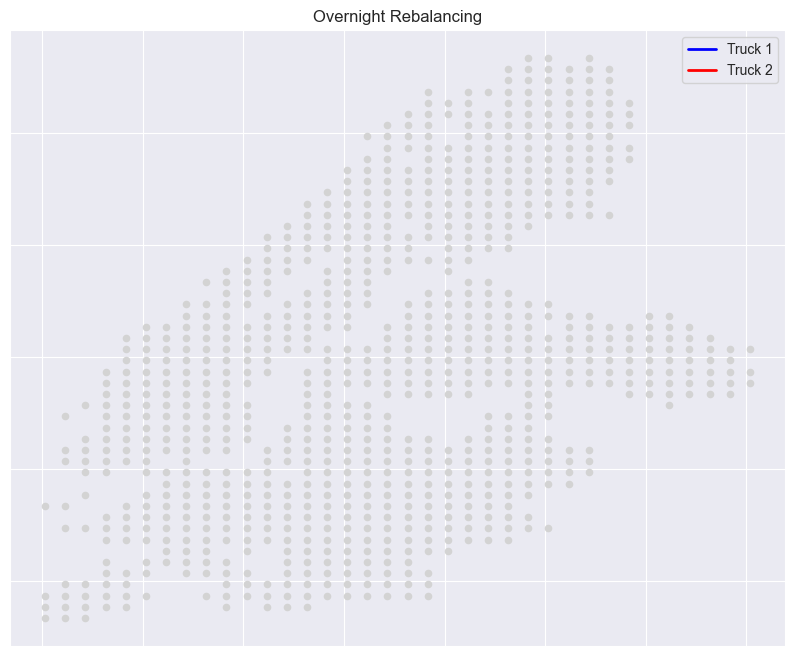

In [15]:
start_levels = {cluster.name: cluster.curr_bikes for cluster in model.cluster_dict.values()}
positions = {cluster.name: (cluster.lon, cluster.lat) for cluster in model.cluster_dict.values()}
adjacency = model.get_adjacent_clusters()
clusters = [cluster for cluster in model.cluster_dict.keys()]

T = 40
K = 2
L = 30


ip_model, x, y, b = ip.create_model(T=T, K=K, L=L, 
                start_levels=start_levels,
                stations=clusters, 
                optimal_levels=opt_state, 
                positions=positions,  
                neighbors=adjacency)

truck_paths = ip.graph_model(x, b, K, T, clusters, positions)

In [6]:
with open("../new-york-city-boroughs.geojson") as f:
    boroughs_geojson = simplejson.load(f)
    
def classify_borough(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_borough = 'Unknown'
    
    for feature in boroughs_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
        # Calculate the distance to the nearest point on the polygon
        nearest_point = nearest_points(point, polygon)[1]
        distance = point.distance(nearest_point)
        if distance < min_distance:
            min_distance = distance
            nearest_borough = feature['properties']['name']
    
    return nearest_borough

In [7]:
boro_dict = {}
for cluster in model.cluster_dict.values():
    boro_dict[cluster.name] = classify_borough(cluster.lat, cluster.lon, boroughs_geojson)

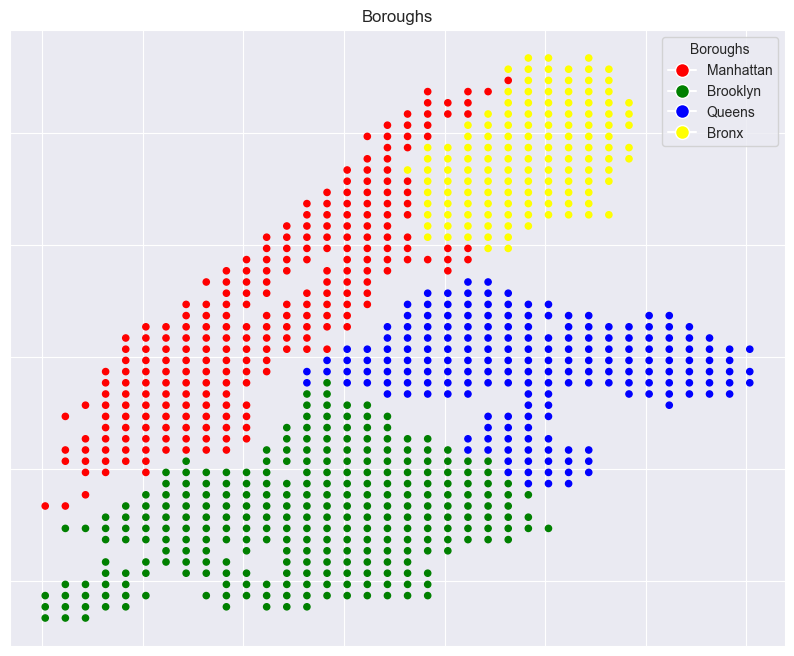

In [8]:
color_map = {'Manhattan': 'red', 'Brooklyn': 'green', 'Queens': 'blue', 'Bronx': 'yellow'}

G = nx.DiGraph()

positions = {}
node_colors = []

for cluster in model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    borough = boro_dict.get(cluster.name, 'Unknown')
    node_colors.append(color_map.get(borough, 'lightgray'))  # Default to 'lightgray' if borough not found

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, positions, node_size=20, node_color=node_colors)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=borough, markersize=10, markerfacecolor=color) 
                   for borough, color in color_map.items()]
plt.legend(handles=legend_elements, title="Boroughs")
plt.title("Boroughs")
plt.show()


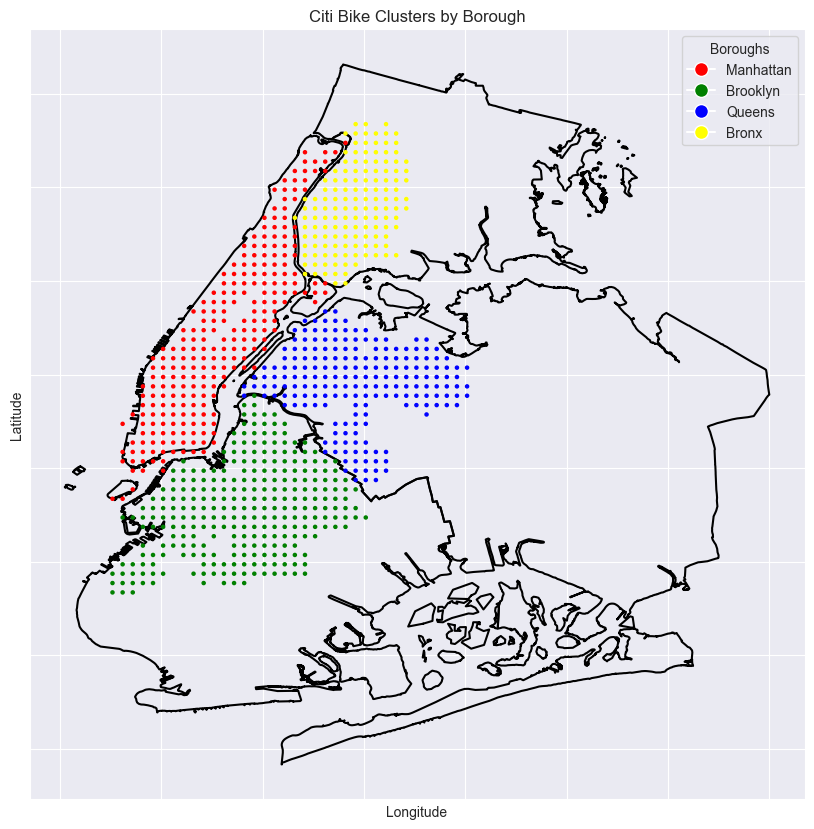

In [9]:
with open('../new-york-city-boroughs.geojson') as f:
    geojson_data = load(f)
    
# Extract the geometries and borough names
geometries = []
borough_names = []

for feature in geojson_data['features']:
    geom = shape(feature['geometry'])
    borough_name = feature['properties']['name']
    
    if borough_name in color_map:  # Only add boroughs that have nodes
        geometries.append(geom)
        borough_names.append(borough_name)

# Plot the borough boundaries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, borough_name in zip(geometries, borough_names):
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y, 'k')

# For the nodes
color_map = {'Manhattan': 'red', 'Brooklyn': 'green', 'Queens': 'blue', 'Bronx': 'yellow'}

G = nx.DiGraph()

positions = {}
node_colors = []

# Assuming cluster_model and boro_dict are defined elsewhere
for cluster in model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    borough = boro_dict.get(cluster.name, 'Unknown')
    if borough in color_map:  # Only add nodes for boroughs in color_map
        node_colors.append(color_map[borough])
    else:
        node_colors.append('lightgray')  # Default color for unknown boroughs

# Draw network nodes on the existing plot
nx.draw_networkx_nodes(G, positions, node_size=5, node_color=node_colors, ax=ax)

# Create legend for boroughs
legend_elements = [Line2D([0], [0], marker='o', color='w', label=borough, markersize=10, markerfacecolor=color) 
                   for borough, color in color_map.items()]
ax.legend(handles=legend_elements, title="Boroughs")

# Add plot titles and labels
plt.title('Citi Bike Clusters by Borough')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


In [10]:
with open("../nyc-neighborhoods.geo.json") as f:
    neighborhoods_geojson = simplejson.load(f)

In [11]:
def classify_neighborhood(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_borough = 'Unknown'
    
    for feature in neighborhoods_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
        # Calculate the distance to the nearest point on the polygon
        nearest_point = nearest_points(point, polygon)[1]
        distance = point.distance(nearest_point)
        if distance < min_distance:
            min_distance = distance
            nearest_neighborhood = feature['properties']['name']
    
    return nearest_neighborhood

In [12]:
neighborhood_dict = {}
for cluster in model.cluster_dict.values():
    neighborhood_dict[cluster.name] = classify_neighborhood(cluster.lat, cluster.lon, neighborhoods_geojson)

# List of neighborhoods that actually have stations in them
neighborhood_list, cluster_list = [], [] # cluster list is of objects, not names
for cluster in neighborhood_dict.keys():
    if boro_dict[cluster] == "Brooklyn":
        cluster_list.append(model.cluster_dict[cluster])
        if neighborhood_dict[cluster] not in neighborhood_list:
            neighborhood_list.append(neighborhood_dict[cluster])

/Users/jarrett/Documents/GitHub/CSUREMM/venv/lib/python3.9/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


In [13]:
# List of neighborhoods that actually have stations in them
neighborhood_list, cluster_list = [], [] # cluster list is of objects, not names
for cluster in neighborhood_dict.keys():
    if boro_dict[cluster] == "Brooklyn":
        cluster_list.append(model.cluster_dict[cluster])
        if neighborhood_dict[cluster] not in neighborhood_list:
            neighborhood_list.append(neighborhood_dict[cluster])

# List of bad neighborhoods to highlight in our graph
bad_neighborhoods = ['Flatbush', 'East Flatbush-Farragut', 'Sunset Park East', 
                     'Sunset Park West', 'Crown Heights South', 'Crown Heights North']

In [15]:
clusters = [cluster.name for cluster in cluster_list]
start_levels = {cluster.name: cluster.curr_bikes for cluster in model.cluster_dict.values() if cluster.name in clusters}
positions = {cluster.name: (cluster.lon, cluster.lat) for cluster in model.cluster_dict.values() if cluster.name in clusters}
adjacency = model.get_adjacent_clusters()
neighbors = adjacency.copy()
for cluster in adjacency.keys():
    if cluster not in clusters:
        del neighbors[cluster]

In [16]:
optimal_levels = opt_state.copy()
for cluster in opt_state.keys():
    if cluster not in clusters:
        del optimal_levels[cluster]
        

In [17]:
for neighbor_list in neighbors.values():
    for cluster in neighbor_list:
        if cluster not in clusters or cluster == 731: # WHYYYYYYYY
            neighbor_list.remove(cluster)

In [18]:
T = 60
K = 1
L = 10

In [19]:
ip_model, x1, y, b = ip.create_model(T=T, K=K, L=L,  #changed to x1 for graphing part
                stations=clusters,
                start_levels=start_levels, 
                optimal_levels=optimal_levels, 
                positions=positions,  
                neighbors=neighbors)
# truck_paths = ip.graph_model(x, b, K, T, clusters, positions)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-01


KeyError: (1022, 1, 1)

In [ ]:
stations = clusters
node_size = 20
title = "Brooklyn Rebalancing"


geojson_data = neighborhoods_geojson

# Extract the geometries and properties (neighborhood names)
geometries = []
properties = []

for feature in geojson_data['features']:
    if feature['properties']['name'] in neighborhood_list:
        geometry = shape(feature['geometry'])
        properties.append(feature['properties'])
        geometries.append(geometry)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))

for geom, prop in zip(geometries, properties):
    neighborhood_name = prop['name']
    if isinstance(geom, Polygon):
        x, y = geom.exterior.xy
        # if neighborhood_name in bad_neighborhoods:
        #     ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
        ax.plot(x, y, 'k')
    elif isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            x, y = polygon.exterior.xy
            # if neighborhood_name in bad_neighborhoods:
            #     ax.fill(x, y, 'red', alpha=0.5)  # Fill in red with transparency
            ax.plot(x, y, 'k')

truck_paths = {}
    
# if model.status == GRB.OPTIMAL:
if True:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x1[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s, '{} bikes'.format(int(b[t,k].x))))
                    break
        truck_paths[k] = path
        # print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")

G = nx.DiGraph()

# Add nodes
for station in stations:
    G.add_node(station)

# Add edges with arrows for each truck path
for k, path in truck_paths.items():
    for i in range(len(path) - 1):
        t1, s1 = path[i][:2]
        t2, s2 = path[i + 1][:2]
        G.add_edge(s1, s2, truck=k, time_step=t1)

edge_colors = ['blue', 'red', 'green', 'purple']  # Different colors for different trucks

# plt.figure(figsize=(10, 8))
for k, path in truck_paths.items():
    # edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
    # The above includes time steps where the trucks don't move. Below I have removed such trips
    edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][1] != path[i + 1][1]]
    nx.draw_networkx_edges(G, positions, edgelist=edges, arrowstyle='->', arrowsize=10, 
                           edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')

nx.draw_networkx_nodes(G, positions, node_size= node_size, node_color='lightgray')
# If we want to add labels we can
# nx.draw_networkx_labels(G, positions, font_size=10)

from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], color=edge_colors[k - 1], lw=2, label=f'Truck {k}') for k in range(1, K+1)]
plt.legend(handles=legend_handles)

plt.title(title)
plt.show()